In [31]:
import sys
import matplotlib.pyplot as plt
import mplfinance as mpl
import numpy as np
 
# Avoid AttributeError: module 'sqlalchemy' has no attribute 'orm'
import sqlalchemy.orm  # noqa: F401

sys.path.append("..")
from bitflyer_hft_bot.db.database import initialize_database
from bitflyer_hft_bot.db import crud
from backtest.visualize.ohlcv import ohlcv_plot
from backtest.utils.utils import get_ohlcv_df, get_predict_df, match_timestamp_for_ohlcv
from backtest.backtest_trade.richman_backtest import richman_backtest

/Users/akiranoda/projects/bitflyer-websocket/.venv/lib/python3.9/site-packages/mplfinance/_arg_validators.py:35: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


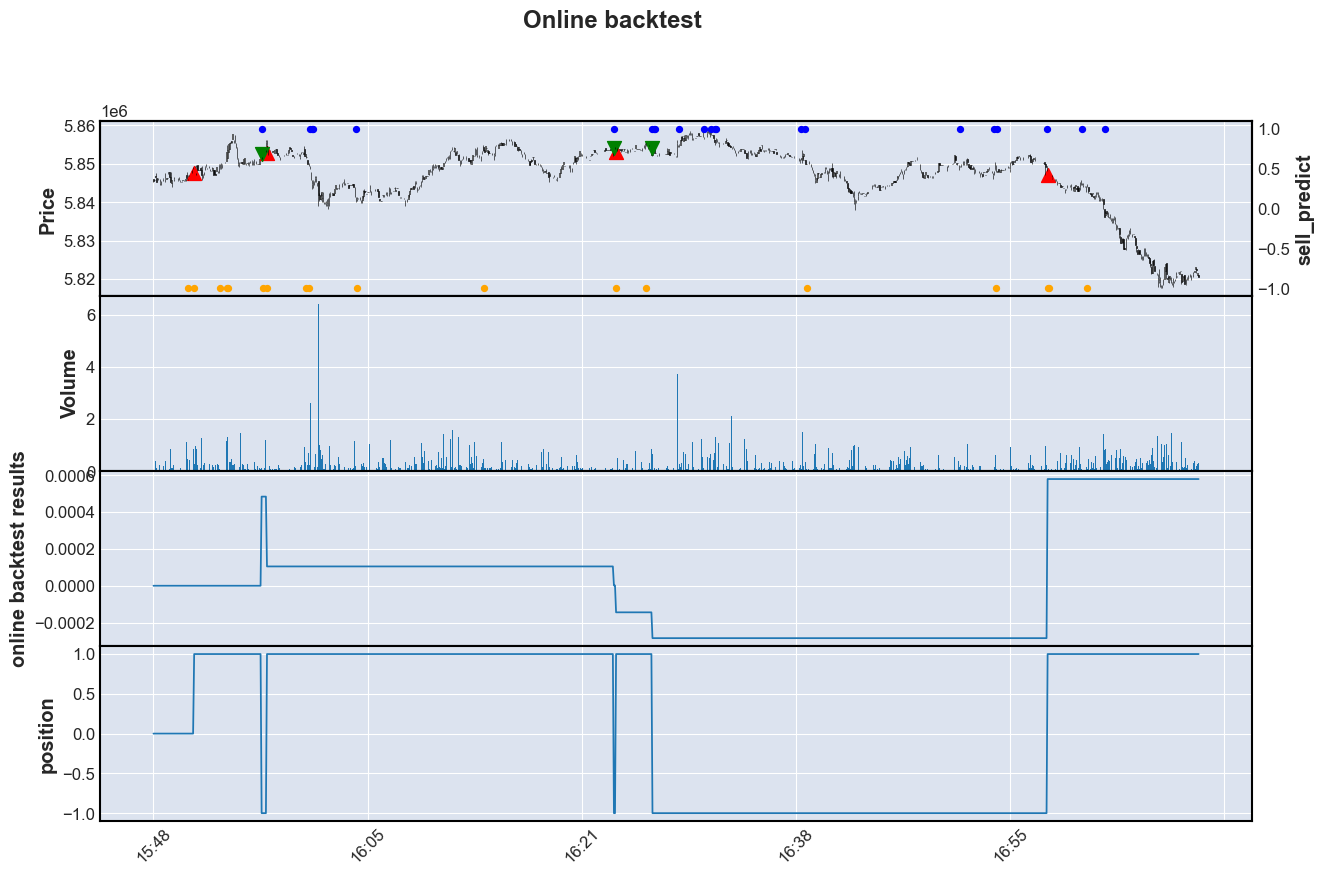

In [38]:
symbol = "FX_BTC_JPY"

_, SessionLocal = initialize_database(uri="sqlite:///../example.db")
with SessionLocal() as db:
    ohlcv_data = crud.get_ohlcv_with_symbol(db=db, symbol=symbol)
    predict_data = crud.get_predict_items(db=db, symbol=symbol)

# fig, axes = plt.subplots(2, 1, figsize=(16, 8))
# axes = axes.flatten()

time_span = 5
ohlcv_df = get_ohlcv_df(ohlcv_data, time_span=time_span)
buy_df, sell_df = get_predict_df(predict_data)
timestamped_buy_df = match_timestamp_for_ohlcv(ohlcv_df, buy_df, time_span)
timestamped_sell_df = match_timestamp_for_ohlcv(ohlcv_df, sell_df, time_span)
result_online = richman_backtest(ohlcv_df, buy_df=timestamped_buy_df, sell_df=timestamped_sell_df)

# local data backtest
local_timestamped_buy_df = timestamped_buy_df.copy()
local_timestamped_sell_df = timestamped_sell_df.copy()
pips = 1000
local_timestamped_buy_df['price'] = ohlcv_df.loc[:,'close'] - pips
local_timestamped_sell_df['price'] = ohlcv_df.loc[:,'close'] + pips
result_local = richman_backtest(ohlcv_df, buy_df=local_timestamped_buy_df, sell_df=local_timestamped_sell_df)

/Users/akiranoda/projects/bitflyer-websocket/.venv/lib/python3.9/site-packages/mplfinance/_arg_validators.py:35: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


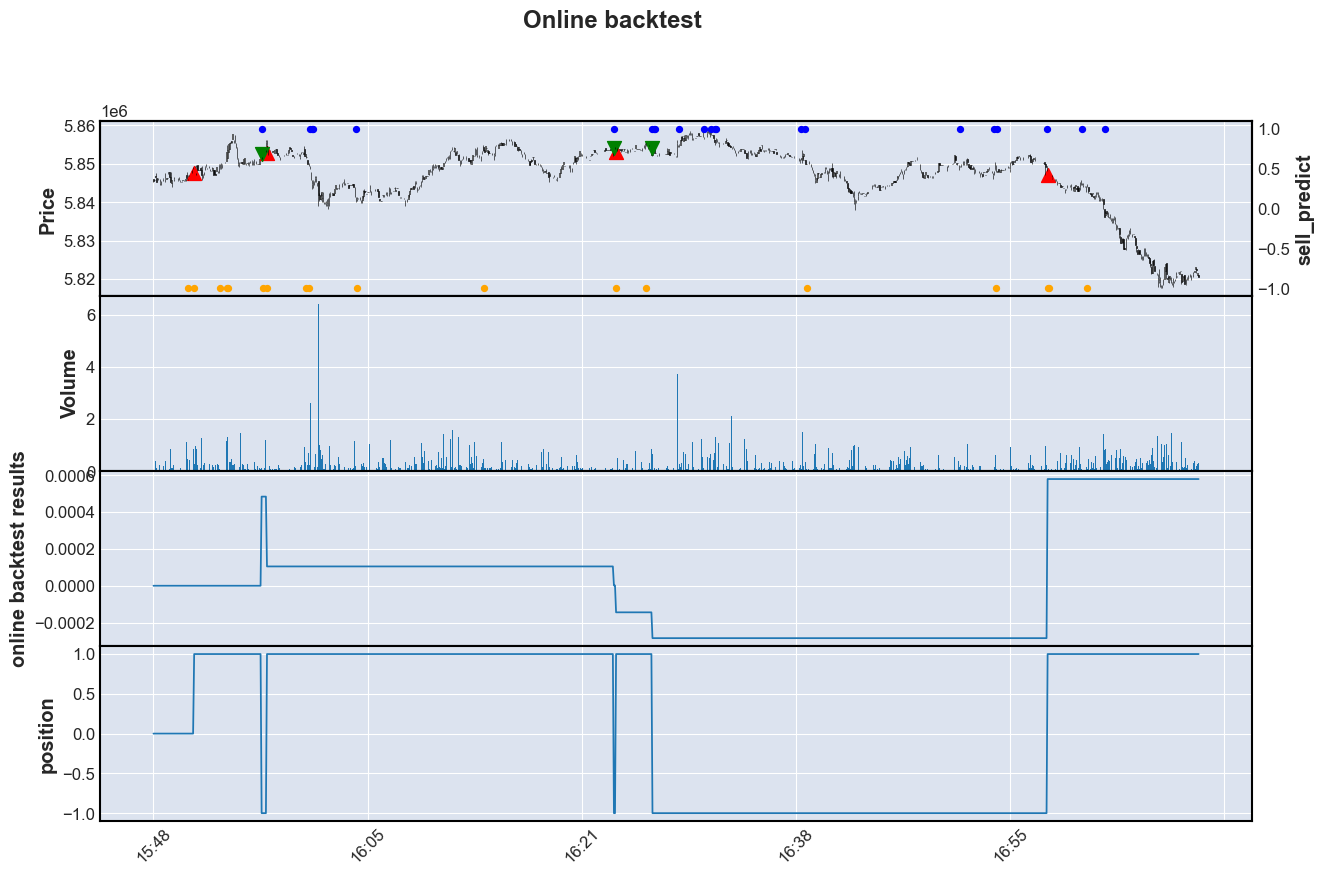

In [40]:
mpl_adds = [
    # Prediction plot
    mpl.make_addplot(np.where(timestamped_buy_df["is_entry"] == True, -1, np.nan), type="scatter", ylabel="buy_predict", color="orange", y_on_right=False),
    mpl.make_addplot(np.where(timestamped_sell_df["is_entry"] == True, 1, np.nan), type="scatter", ylabel="sell_predict", color="blue", y_on_right=False),

    # Entry plot
    mpl.make_addplot(result_online["buy_entry_price"] - 1000, type="scatter", markersize=100, marker="^", color="r"),
    mpl.make_addplot(result_online["sell_entry_price"] + 1000, type="scatter", markersize=100, marker="v", color="g"),

    # Volume plot
    mpl.make_addplot(ohlcv_df["volume"], type="bar", panel=1, ylabel="Volume", y_on_right=False),

    # Cumulative plot
    mpl.make_addplot(result_online["cumulative_return"], type="line", panel=2, ylabel="online backtest results", y_on_right=False),

    # Position plot
    mpl.make_addplot(result_online["position"], type="line", panel=3, ylabel="position", y_on_right=False),
]
mpl.plot(ohlcv_df, type="candle", addplot=mpl_adds, figsize=(16, 10), panel_ratios=(1,1), figratio=(1,1), figscale=1.5, title="Online backtest")
plt.close()

/Users/akiranoda/projects/bitflyer-websocket/.venv/lib/python3.9/site-packages/mplfinance/_arg_validators.py:35: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


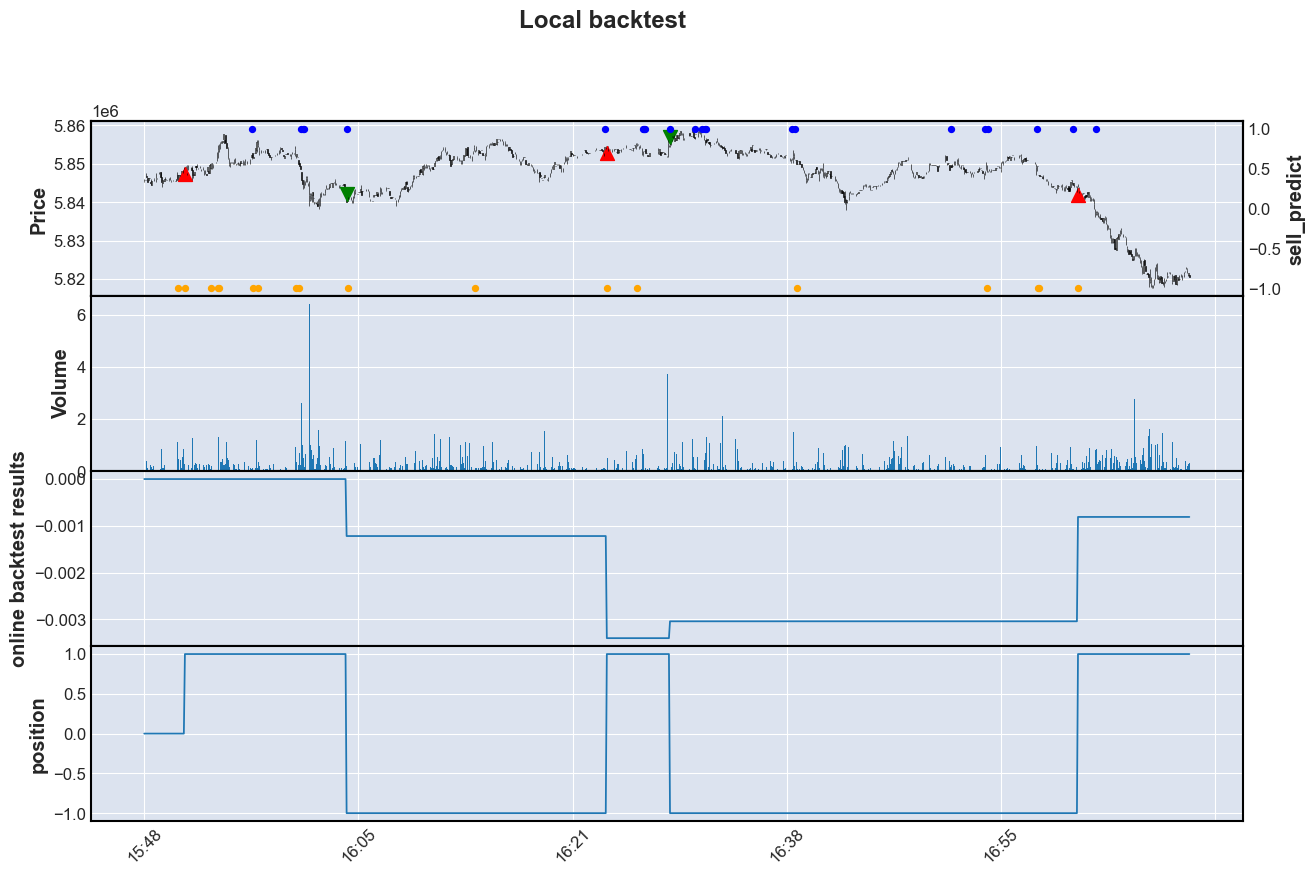

In [39]:
mpl_adds = [
    # Prediction plot
    mpl.make_addplot(np.where(timestamped_buy_df["is_entry"] == True, -1, np.nan), type="scatter", ylabel="buy_predict", color="orange", y_on_right=False),
    mpl.make_addplot(np.where(timestamped_sell_df["is_entry"] == True, 1, np.nan), type="scatter", ylabel="sell_predict", color="blue", y_on_right=False),

    # Entry plot
    mpl.make_addplot(result_local["buy_entry_price"] - 1000, type="scatter", markersize=100, marker="^", color="r"),
    mpl.make_addplot(result_local["sell_entry_price"] + 1000, type="scatter", markersize=100, marker="v", color="g"),

    # Volume plot
    mpl.make_addplot(ohlcv_df["volume"], type="bar", panel=1, ylabel="Volume", y_on_right=False),

    # Cumulative plot
    mpl.make_addplot(result_local["cumulative_return"], type="line", panel=2, ylabel="online backtest results", y_on_right=False),

    # Position plot
    mpl.make_addplot(result_local["position"], type="line", panel=3, ylabel="position", y_on_right=False),
]
mpl.plot(ohlcv_df, type="candle", addplot=mpl_adds, figsize=(16, 10), panel_ratios=(1,1), figratio=(1,1), figscale=1.5, title="Local backtest")
plt.close()

In [3]:
pips = 500
ohlcv_df["local_buy_price"] = ohlcv_df["close"] - pips
merged_buy_df = timestamped_buy_df.merge(ohlcv_df["local_buy_price"], right_index=True, left_index=True)
merged_buy_df["subt_online_local"] = merged_buy_df["price"] - merged_buy_df["local_buy_price"]
merged_buy_df[['price', "local_buy_price", "subt_online_local"]].tail(30)

,price,local_buy_price,subt_online_local
timestamp,,,
2022-03-30 03:59:30+00:00,5925634.0,5927107.0,-1473.0
2022-03-30 03:59:35+00:00,5925634.0,5927107.0,-1473.0
2022-03-30 03:59:40+00:00,5925634.0,5927107.0,-1473.0
2022-03-30 03:59:45+00:00,5925634.0,5927107.0,-1473.0
2022-03-30 03:59:50+00:00,5925634.0,5927107.0,-1473.0
2022-03-30 03:59:55+00:00,5925634.0,5927107.0,-1473.0
2022-03-30 04:00:00+00:00,5925634.0,5927107.0,-1473.0
2022-03-30 04:00:05+00:00,5925634.0,5927107.0,-1473.0
2022-03-30 04:00:10+00:00,5925634.0,5927107.0,-1473.0
